<a href="https://colab.research.google.com/github/Imran012x/Hilsha_CoLab/blob/main/handwriting_recognition_using_crnn_in_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we'll go through the steps to train a CRNN (CNN+RNN) model for handwriting recognition. The model will be trained using the CTC(Connectionist Temporal Classification) loss.


![Webp.net-resizeimage.jpg](attachment:Webp.net-resizeimage.jpg)

In [ ]:
# !pip install kora
# from kora import files
# files.upload_dir()  # This opens a file browser to select a folder.


In [1]:
from google.colab import files
uploaded = files.upload()  # This allows you to select and upload the .zip file.


Saving augment.zip to augment.zip


In [2]:
import os
import zipfile

with zipfile.ZipFile('augment.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sardin')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Lets start by importing the necessary libraries. I'll be using Keras for building our CRNN model.

In [ ]:
import os
import cv2
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
tf.config.run_functions_eagerly(True)

2025-01-19 00:13:18.591498: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 00:13:18.735620: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 00:13:18.973114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737223999.102910  261047 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737223999.131070  261047 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 00:13:19.445543: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## Load and view data

In [ ]:
train = pd.read_csv('./written_name_train_v2.csv')
valid = pd.read_csv('./written_name_validation_v2.csv')

In [ ]:
train.shape

(330961, 2)

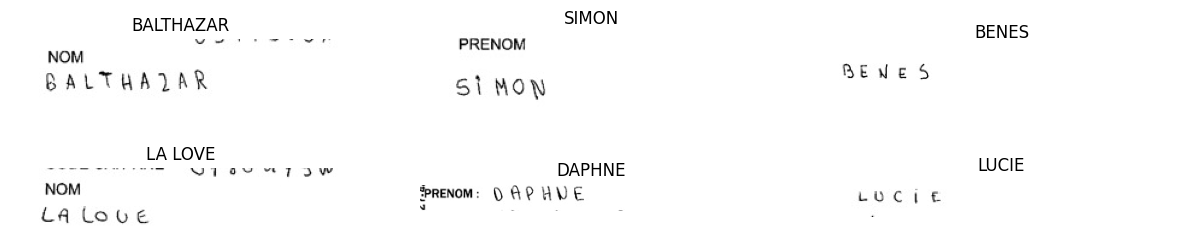

In [ ]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = './train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## Cleaning Data

Let's check for NaNs in our label.

In [ ]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [ ]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

Also, there are some images in our data with the label 'UNREADABLE'. Lets check those images and remove them.

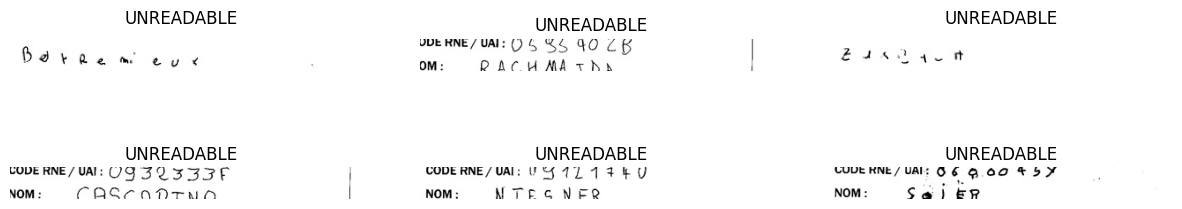

In [ ]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = './train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

There are some labels which are in lowercase. To maintain uniformity in the labels, I convert all the labels to uppercase.

In [ ]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

Reset the index and we are done with cleaning.

In [ ]:
train.reset_index(inplace = True, drop=True)
valid.reset_index(inplace = True, drop=True)

In [ ]:
train.shape[0]/128

2580.421875

## Preprocessing and preparing the images for training

* The images are loaded as grayscale and reshaped to width 256 and height 64.  
* The width and height are cropped if they are greater than 256 and 64 respectively. If they are smaller, then the image is padded with white pixels. Finally the image is rotated clockwise to bring the image shape to (x, y).
* The image is then normalized to range [0, 1]

In [ ]:
def preprocess(img):
    (h, w) = img.shape

    final_img = np.ones([64, 256])*255 # blank white image

    # crop
    if w > 256:
        img = img[:, :256]

    if h > 64:
        img = img[:64, :]


    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

The model will be trained on 30000 images and validate on 3000 images

In [ ]:
# train_size = 30000
valid_size= 3000

In [ ]:
valid_x = []

for i in range(valid_size):
    img_dir = './validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [ ]:
# train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

## Preparing the labels for CTC Loss

Learn more about CTC loss and why its amazing for text recognition from [here](https://theailearner.com/2019/05/29/connectionist-temporal-classificationctc/).

The labels have to be converted to numbers which represent each character in the training set. The 'alphabets' consist of A-Z and three special characters (-  '  and space).

In [ ]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels
batch_size = 128

def label_to_num(label):
    label_num = []
    for ch in label:

            label_num.append(alphabets.find(ch) if alphabets.find(ch)!=-1 else alphabets.find('-'))

    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [ ]:
name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

JEBASTIN 
 [ 9  4  1  0 18 19  8 13]


* **train_y** contains the true labels converted to numbers and padded with -1. The length of each label is equal to max_str_len.
* **train_label_len** contains the length of each true label (without padding)
* **train_input_len** contains the length of each predicted label. The length of all the predicted labels is constant i.e number of timestamps - 2.  
* **train_output** is a dummy output for ctc loss.


# Use gnerator for same purpose

In [ ]:
train.shape

(330294, 2)

In [ ]:
# path = '/kaggle/input/handwriting-recognition/train_v2/train/'

# counts = []
# for row, val in train.iloc[37000:40000].iterrows():
# #     pass
#     img_dir = os.path.join(path, val['FILENAME'])
#     image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
#     counts.append(len(val['IDENTITY']))
# print(counts)

In [ ]:
len(train.iloc[39128]['IDENTITY'])

34

In [ ]:
directory = './train_v2/train/'

def image_generator(path):
        for row, val in  train.iterrows(): #need improvement
#             try:
                img_dir = os.path.join(path, val['FILENAME'])
                image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
                image = preprocess(image)[..., np.newaxis]
        #         print(image.shape)
                image = image/255.
                if image.shape !=(256,64,1):
                    break
        #         train_label_len[i] = len(train.loc[i, 'IDENTITY'])
                if (len(val['IDENTITY'])>max_str_len):
                    continue
                labels = label_to_num(val['IDENTITY'])
                yield (image, labels)
#             except Exception as e:
#                 continue


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
# # dataset = tf.data.Dataset.from_generator(lambda: image_generator(directory), output_types=())
# directory = '/kaggle/input/handwriting-recognition/train_v2/train/'

dataset = tf.data.Dataset.from_generator(lambda: image_generator(directory), (tf.float32, tf.float32))# , ([256, 64,1], [None]))
def foo(*val):
    xl = val[0]
    lab = val[1]
    lab_len = len(lab)
    one_pad = -tf.ones((max_str_len - lab_len))#*(-1)
    y = tf.concat([lab, one_pad], -1)

    return xl, y, [num_of_timestamps-2], [lab_len], [0]

dataset = dataset.map(foo).batch(batch_size)
dataset_final = dataset.map(lambda *x: (x[0:-1],x[-1])).prefetch(AUTOTUNE)


Instructions for updating:
Use output_signature instead


2025-01-19 00:13:29.425214: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/imran/Documents/Drive/VE/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
# # c = 0
# for j in dataset_final:
# #     c+=1
# # #     if c>1:
#     print(len(j))
#     print(j[0][1])
# #     print(j[0][0].shape, j[0][1].shape,  j[0][2].shape, j[0][3].shape, j[1].shape)
# #     print(j[0][0].shape, j[0][1].shape,  j[0][2], j[0][3], j[1].shape)
#     break

In [ ]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])

In [ ]:
# print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100],
#       '\ntrain_input_len : ', train_input_len[100])

## Building our model


In [ ]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((num_of_timestamps, 1024)), name='reshape')(inner)
inner = Dense(num_of_timestamps, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 256, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 256, 64, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max1 (MaxPooling2D)             │ (None, 128, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 128, 32, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 32, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2 (MaxPooling2D)             │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 64, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max3 (MaxPooling2D)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64, 64)         │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm1 (Bidirectional)           │ (None, 64, 512)        │       657,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (Bidirectional)           │ (None, 64, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64, 30)         │        15,390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 64, 30)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,406,878 (9.18 MB)

 Trainable params: 2,406,430 (9.18 MB)

 Non-trainable params: 448 (1.75 KB)

The output shape of the predictions is (64, 30). The model predicts words of 64 characters and each character contains the probability of the 30 alphabets which we defined earlier.  

In [ ]:
# # the ctc loss function
# def ctc_lambda_func(args):
#     y_pred, labels, input_length, label_length = args
#     # the 2 is critical here since the first couple outputs of the RNN
#     # tend to be garbage
#     y_pred = y_pred[:, 2:, :]
#     return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


import tensorflow as tf

# Define the CTC loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    # Reshape y_pred to match the required shape for tf.nn.ctc_loss
    y_pred = tf.transpose(y_pred, perm=[1, 0, 2])  # Time-major format

    # Compute CTC loss
    ctc_loss = tf.nn.ctc_loss(
        labels=tf.cast(labels, tf.int32),
        logits=y_pred,
        label_length=tf.squeeze(label_length),
        logit_length=tf.squeeze(input_length),
        logits_time_major=True,
        blank_index=-1  # Default is the last class
    )
    return tf.reduce_mean(ctc_loss)


In [ ]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

## Train our model

In [ ]:
import tensorflow as tf

def custom_ctc_loss(y_true, y_pred):
    input_length = tf.reduce_sum(tf.ones_like(y_pred[:, :, 0]), axis=-1)
    label_length = tf.reduce_sum(tf.ones_like(y_true), axis=-1)
    return tf.nn.ctc_loss(
        labels=y_true,
        logits=y_pred,
        label_length=label_length,
        logit_length=input_length,
        logits_time_major=False
    )


In [ ]:
# # the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001))


In [ ]:

model_final.fit(dataset_final, epochs=8,verbose=1)
# model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output,
#                 validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
#                 epochs=60, batch_size=128)

Epoch 1/8


In [ ]:
model.save('/kaggle/working/model', save_format='h5')

In [ ]:
ssss

In [ ]:
# model_final.load('/kaggle/working/model', save_format='h5')
from tensorflow import keras

# final_model = keras.models.load_model('/kaggle/working/model', compile=False)


In [ ]:
my_model = keras.models.load_model('/kaggle/working/model')#, compile=False)

In [ ]:
# from IPython.display import FileLink
# import os
# os.chdir(r'/kaggle/working')
# FileLink(r'model')

In [ ]:
# train_generator = get_batch_generator(image_generator(directory),batch_examples)

# model_final.fit(dataset_final.repeat(2), epochs=9)

In [ ]:
# batch_examples = 128
# train_generator = get_batch_generator(image_generator(directory),batch_examples)
# .fit_generator(
#     generator=train_generator,
#     steps_per_epoch=train.shape[0]//batch_examples,
#     epochs=10,)

## Check model performance on validation set

In [ ]:
preds = my_model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1],
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

In [ ]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)

    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr :
        correct += 1

print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 86.14%
Correct words predicted      : 75.40%


## Some predictions on test set

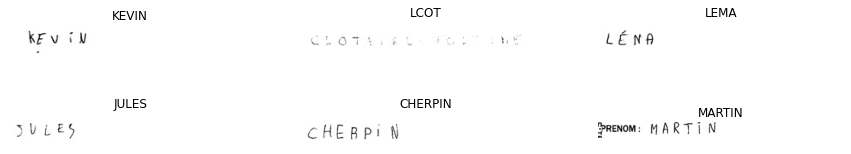

In [ ]:
test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')

    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## transfer learning

In [ ]:
import string
import json


In [ ]:
batch_size = 8
alphabets = string.digits +"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "

def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))

    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [ ]:
width = 256
height = 64
# num_of_timestamps = 50
# max_str_len = num_of_timestamps
rnn_steps_to_discard = 2
all_data = '/kaggle/input/tags-licenseplate/ocr-licence-plate.csv'
data_all = pd.read_csv(all_data)

In [ ]:
def yolo_to_abs(data_dict):#, scale=100.0):
    cord = {}

    original_width = data_dict['original_width']
    original_height = data_dict['original_height']

    pixel_x = int(data_dict['x']/100. * original_width)
    pixel_y = int(data_dict['y']/100. * original_height)
    pixel_width = int(data_dict['width']/100. * original_width)
    pixel_height = int(data_dict['height']/100. * original_height)
#     return[pixel_x, pixel_y, pixel_width, pixel_height]
    cord['x1'] = pixel_x #- pixel_width #/2)*original_width
    cord['y1'] = pixel_y #- pixel_height#/2)*original_height
    cord['x2'] = pixel_x + pixel_width#/2)*original_width
    cord['y2'] = pixel_y + pixel_height#/2)*original_height
    return cord

In [ ]:
def preprocess_2(image, width: int, height: int, cval: int = 255, mode="letterbox", return_scale=False,):
    """Obtain a new image, fit to the specified size.
    Args:
        image: The input image
        width: The new width
        height: The new height
        cval: The constant value to use to fill the remaining areas of
            the image
        return_scale: Whether to return the scale used for the image
    Returns:
        The new image
    """
    fitted = None
    x_scale = width / image.shape[1]
    y_scale = height / image.shape[0]
    if x_scale == 1 and y_scale == 1:
        fitted = image
        scale = 1
    elif (x_scale <= y_scale and mode == "letterbox") or (
        x_scale >= y_scale and mode == "crop"
    ):
        scale = width / image.shape[1]
        resize_width = width
        resize_height = (width / image.shape[1]) * image.shape[0]
    else:
        scale = height / image.shape[0]
        resize_height = height
        resize_width = scale * image.shape[1]
    if fitted is None:
        resize_width, resize_height = map(int, [resize_width, resize_height])
        if mode == "letterbox":
            fitted = np.zeros((height, width, 3), dtype="uint8") + cval
            image = cv2.resize(image, dsize=(resize_width, resize_height))
            fitted[: image.shape[0], : image.shape[1]] = image[:height, :width]
        elif mode == "crop":
            image = cv2.resize(image, dsize=(resize_width, resize_height))
            fitted = image[:height, :width]
        else:
            raise NotImplementedError(f"Unsupported mode: {mode}")
    if not return_scale:
        return fitted
    return fitted, scale

In [ ]:
def image_generator_2(path, pd_data):
    for row, val in  pd_data.iterrows():                         # need improvement
        img_dir = os.path.join(path, val['ocr'].split('-')[-1])
        image = cv2.imread(img_dir, cv2.IMREAD_ANYCOLOR)
#             image = preprocess(image)[..., np.newaxis]
        try:
            labels = json.loads(val['transcription'])
        except ValueError:
            labels = str(val['transcription'])
        for num, bbox in enumerate(json.loads(val['bbox'])):
            cart_cord = yolo_to_abs(bbox)
            crop_img = image[cart_cord['y1']:cart_cord['y2'],
                             cart_cord['x1']:cart_cord['x2']]
            process_img = preprocess_2(crop_img, width=width,height=height)
            process_img = cv2.rotate(process_img, cv2.ROTATE_90_CLOCKWISE)
            process_img = cv2.cvtColor(process_img, cv2.COLOR_RGB2GRAY).astype("float32")[..., np.newaxis]
            process_img /=255
            if isinstance(labels, list):
                yield process_img, label_to_num(labels[num])
            else:
                yield process_img, label_to_num(str(labels))
#             image = image/255.
#             if image.shape !=(256,64,1):
#                 break
    #         train_label_len[i] = len(train.loc[i, 'IDENTITY'])
#             if (len(val['IDENTITY'])>max_str_len):
#                 continue
#             labels = val['transcription']
#             labels = label_to_num(val['IDENTITY'])
#             yield (image, labels)
#         except Exception as e:
#             continue
def data_joiner(*val):
    xl = val[0]
    lab = val[1]
    lab_len = len(lab)
    one_pad = -tf.ones((max_str_len - lab_len - rnn_steps_to_discard))#*(-1)
    y = tf.concat([lab, one_pad], -1)

    return xl, y, [num_of_timestamps-2], [lab_len], [0]


In [ ]:
int(len(data_all)*.8)

251

In [ ]:
cuttof = 220
train = data_all.iloc[:cuttof]
test = data_all.iloc[cuttof:]

In [ ]:
batch_size = 8

directory = '/kaggle/input/car-plate-detection/images/'

dataset = tf.data.Dataset.from_generator(lambda: image_generator_2(directory, train), (tf.float32, tf.float32))# , ([256, 64,1], [None]))
dataset = dataset.map(data_joiner).batch(batch_size)
dataset_train= dataset.map(lambda *x: (x[0:-1],x[-1]))

In [ ]:
# for i in dataset_train:
#     print(i)
#     break

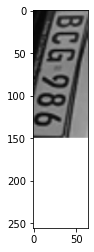

In [ ]:
# plt.plot(i[0][0][0,:,:,:])
# plt.imshow(i[0][0][0])
plt.imshow(i[0][0][0,:,:,0], cmap='gray')

In [ ]:

decoder_layer = Dense(len(alphabets) + 1, kernel_initializer='he_normal',
                           activation='softmax',  name='fc_12')(my_model.layers[-3].output)
x = Lambda(lambda x: x[:, rnn_steps_to_discard:])(decoder_layer)


new_model = Model(inputs=my_model.inputs, outputs=x)
# prediction_model = keras.models.Model(inputs=new_model.inputs, outputs=CTCDecoder()(new_model.output))

In [ ]:
# for layer in new_model.layers[:-7]:
# #     print(layer)
#      layer.trainable = False

In [ ]:
labels = Input(name="labels", shape=[new_model.output_shape[1]], dtype="float32")

label_length = Input(shape=[1])
input_length = Input(shape=[1])

loss = Lambda(lambda x: K.ctc_batch_cost(y_true=x[0], y_pred=x[1], input_length=x[2], label_length=x[3])
                          )([labels, new_model.output, input_length, label_length])
training_model =  Model(inputs=[new_model.input, labels, input_length, label_length], outputs=loss)

In [ ]:
# for layer in new_model.layers[:-9]:
# #     print(layer)
#      layer.trainable = False

In [ ]:
training_model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 64, 1)] 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 64, 32)  320         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 64, 32)  128         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 64, 32)  0           batch_normalization[0][0]        
______________________________________________________________________________________

In [ ]:
# kwargs = {}
# kwargs["optimizer"] = Adam(lr = 0.0001) #"RMSprop" #Adam
# kwargs["loss"] = lambda _, y_pred: y_pred
training_model.compile(loss=lambda _, y_pred: y_pred,optimizer=Adam(lr = 0.0001))

In [ ]:
training_model.fit(dataset_train, epochs=8)#,verbose=1)

Epoch 1/8
30/30 [==============================] - 4s 119ms/step - loss: 127.6380
Epoch 2/8
30/30 [==============================] - 4s 136ms/step - loss: 33.0746
Epoch 3/8
30/30 [==============================] - 4s 117ms/step - loss: 29.0888
Epoch 4/8
30/30 [==============================] - 4s 135ms/step - loss: 28.2281
Epoch 5/8
30/30 [==============================] - 4s 127ms/step - loss: 27.8501
Epoch 6/8
30/30 [==============================] - 4s 121ms/step - loss: 27.5950
Epoch 7/8
30/30 [==============================] - 4s 121ms/step - loss: 27.3758
Epoch 8/8
30/30 [==============================] - 4s 130ms/step - loss: 27.2014


In [ ]:
plt.imshow(i[0][0][0,:,:,0], cmap='gray')

TypeError: 'int' object is not subscriptable

In [ ]:
batch_size = 1

dataset = tf.data.Dataset.from_generator(
    lambda: image_generator_2(directory, test), (tf.float32, tf.float32)).map(data_joiner).batch(batch_size)

dataset_test= dataset.map(lambda *x: (x[0:-1],x[-1]))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [ ]:
for smaple_test in dataset_test:
#     print(smaple_test)
    break

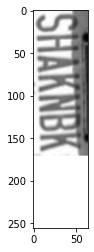

In [ ]:
# plt.imshow(smaple_test[0][0][0])
# plt.plot(i[0][0][0,:,:,:])
# plt.imshow(i[0][0][0])
plt.imshow(smaple_test[0][0][0,:,:,0], cmap='gray')

In [ ]:
labels = []
test_images = []
for X,y in dataset_test:
    test_images.append(X[0].numpy()[0])
    labels.append(X[1])

In [ ]:
preds = new_model.predict(dataset_test)

preds = new_model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1],
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

In [ ]:
decoded = K.get_value(K.ctc_decode(v, input_length=np.ones(v.shape[0])*v.shape[1],
                                   greedy=True)[0][0])

In [ ]:
dataset_test.take(1)

<TakeDataset shapes: ((<unknown>, (None, None), (None, 1), (None, 1)), (None, 1)), types: ((tf.float32, tf.float32, tf.int32, tf.int32), tf.int32)>

In [ ]:
preds = new_model.predict(test_images)

In [ ]:
len(labels)

In [ ]:
preds.shape

In [ ]:
preds = new_model.predict(test_images)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1],
                                   greedy=True)[0][0])

In [ ]:
prediction = []
for i in range(len()):
    prediction.append(num_to_label(decoded[i]))

# bentch mark

In [ ]:
y_true = test.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for x ,y in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)

    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr :
        correct += 1

print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

In [ ]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path='/kaggle/input/keras-ocr/tflite/float16/2/2.tflite')


In [ ]:
dir(interpreter)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_custom_op_registerers',
 '_delegates',
 '_ensure_safe',
 '_get_op_details',
 '_get_ops_details',
 '_get_tensor_details',
 '_interpreter',
 '_safe_to_run',
 '_tf_api_names',
 '_tf_api_names_v1',
 'allocate_tensors',
 'get_input_details',
 'get_output_details',
 'get_tensor',
 'get_tensor_details',
 'invoke',
 'reset_all_variables',
 'resize_tensor_input',
 'set_tensor',
 'tensor']

In [ ]:
interpreter.get_input_details()

[{'name': 'serving_default_input:0',
  'index': 0,
  'shape': array([  1,  31, 200,   1], dtype=int32),
  'shape_signature': array([  1,  31, 200,   1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [ ]:
interpreter.allocate_tensors()  # Needed before execution!

output = interpreter.get_output_details()[0]  # Model has single output.
input = interpreter.get_input_details()[0]  # Model has single input.



In [ ]:
path = '/kaggle/input/car-plate-detection/images'
test_example = test.iloc[0]
# val['ocr'].split('-')[-1])
# path = test_exaple
img_dir = os.path.join(path, test_example['ocr'].split('-')[-1])
image = cv2.imread(img_dir, cv2.IMREAD_ANYCOLOR)
labels = test_example['transcription']

for num, bbox in enumerate(json.loads(test_example['bbox'])):
    cart_cord = yolo_to_abs(bbox)
    crop_img = image[cart_cord['y1']:cart_cord['y2'],
                     cart_cord['x1']:cart_cord['x2']]
    process_img = preprocess_2(crop_img, width=200, height=31)
#     process_img = cv2.rotate(process_img, cv2.ROTATE_90_CLOCKWISE)
    process_img = cv2.cvtColor(process_img, cv2.COLOR_RGB2GRAY).astype("float32")[..., np.newaxis]
    process_img /=255


In [ ]:
arr = process_img[np.newaxis, ...]

In [ ]:
interpreter.set_tensor(input['index'], arr)
interpreter.invoke()
result = interpreter.get_tensor(output['index'])

In [ ]:
DEFAULT_ALPHABET = string.digits + string.ascii_lowercase
def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=DEFAULT_ALPHABET[ch]
    return ret

In [ ]:
result[0]

array([28, 17, 10, 20, 23, 11, 20, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [ ]:
num_to_label(result[0])

'shaknbk'

In [ ]:
labels

'SHAKNBK'